## News Article Similarity Modelling
- Cross encoding 
- Translated data 
- Using Title 

In [1]:
from tqdm.auto import tqdm
import torch 
import random
from torch import nn
from transformers import RobertaTokenizer, PreTrainedTokenizer, DistilBertTokenizer, DistilBertModel, RobertaModel
from sentence_transformers import SentenceTransformer, SentencesDataset, InputExample, losses
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
from torch.nn import CosineEmbeddingLoss
import transformers
#Build up to SBERT model 

/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/anaconda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
deviceNum = 1
device = torch.device("cuda:" + str(deviceNum) if torch.cuda.is_available() else "cpu")


In [3]:
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 0.000000GB


In [4]:
#set seeds 
torch.manual_seed(85)
random.seed(85)

In [5]:
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/translatedCleaned.tsv", sep="\t")
#df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2', 'title1', 'title2', 'url1_lang', 'url2_lang']].dropna()

#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)

#reset index so it is contiguous set of numbers 
leanDf = leanDf.reset_index(drop=True)

#now combine title and text together 
#first add ". " to title 
leanDf["title1"] = leanDf["title1"].apply(lambda x: x + ". ")
leanDf["title2"] = leanDf["title2"].apply(lambda x: x + ". ")

leanDf["text1"] = leanDf["title1"] + leanDf["text1"]
leanDf["text2"] = leanDf["title2"] + leanDf["text2"]


In [6]:
#NOTE: do a language cutoff 
leanDf = leanDf[(leanDf["url1_lang"] == "en") & (leanDf["url2_lang"] == "en")]

In [7]:
testDf = leanDf.copy(deep=True)

testDf["text1"] = testDf["title1"] + testDf["text1"]
testDf["text2"] = testDf["title2"] + testDf["text2"]

testDf.head(3)

,ground_truth,text1,text2,title1,title2,url1_lang,url2_lang
0,0.000000,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,Virginia man arrested in fatal DUI crash in We...,Haiti’s leader marks independence day amid sec...,en,en
1,0.111111,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,Guyana: Three injured after car crashes into u...,Fire kills more than 30 animals at zoo in west...,en,en
2,0.555556,Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",Trump Brings In 2020 At Mar-a-Lago: ‘We’re Goi...,"Trump says he does not expect war with Iran, ‘...",en,en


In [8]:
#we only want to sample validation data from the pairs that are both english 
enDf = leanDf[(leanDf["url1_lang"] == "en") & (leanDf["url2_lang"] == "en")]
validProp = .1
validCount = int(validProp * len(enDf))
print(validCount)
validIndices = random.sample(list(enDf.index), validCount)

#get dataframe with indices of only the original english pairs 
validDf = enDf.loc[validIndices]

#train data should be all rows that aren't in the validation set 
#here we are taking a set difference and then indexing what remains 
trainDf = leanDf.loc[set(leanDf.index) - set(validIndices)]

173


In [9]:
#get data loaded in properly 
trainDataset = Dataset.from_pandas(trainDf)
validDataset = Dataset.from_pandas(validDf)

In [10]:
#link: https://huggingface.co/sentence-transformers/all-mpnet-base-v2
#example of tokenizing 
#tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')
#tokenizer = AutoTokenizer.from_pretrained('Giyaseddin/distilbert-base-cased-finetuned-fake-and-real-news-dataset')

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

Just Sanity checking the special tokens

In [11]:
encoded = tokenizer(trainDataset[0]["text1"], trainDataset[0]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

Token indices sequence length is longer than the specified maximum sequence length for this model (677 > 512). Running this sequence through the model will result in indexing errors


'<s>Virginia man arre'

In [12]:
encoded = tokenizer(trainDataset[3]["text1"], trainDataset[3]["text2"])
tokenizer.decode(encoded["input_ids"])[:20]

"<s>Zomato Buys Uber'"

making sure that only_first works as expected

In [13]:
first = "hello world this is the first part" 
second = "OPE, and I think this will be the second"
encoded = tokenizer(first, second, truncation="longest_first",  max_length=10)
encoded

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


{'input_ids': [0, 42891, 232, 42, 2, 2, 23075, 6, 8, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [14]:
from transformers.utils import logging
logging.set_verbosity_error()
trainDataset = trainDataset.map(lambda x: tokenizer(x["text1"], x["text2"], max_length=500, padding="max_length", truncation=True))
validDataset = validDataset.map(lambda x: tokenizer(x["text1"], x["text2"], max_length=500, padding="max_length", truncation=True))

  0%|          | 0/1565 [00:00<?, ?ex/s]

  0%|          | 0/173 [00:00<?, ?ex/s]

In [15]:
#only need the input information 
trainDataset = trainDataset.remove_columns(["text1", "text2", "__index_level_0__"])
validDataset = validDataset.remove_columns(["text1", "text2", "__index_level_0__"])

In [16]:
# convert dataset features to PyTorch tensors
validDataset.set_format(type='torch', columns=["ground_truth", "input_ids", "attention_mask"])
trainDataset.set_format(type='torch', columns=["ground_truth", "input_ids", "attention_mask"])

In [17]:
# initialize the dataloader
batch_size = 5
trainLoader = torch.utils.data.DataLoader(
    trainDataset, batch_size=batch_size, shuffle=True
)
validLoader = torch.utils.data.DataLoader(
    validDataset, batch_size=1, shuffle=True
)

In [18]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(token_embeddings, attention_mask):
     #First element of model_output contains all token embeddings
    #print(attention_mask.unsqueeze(-1).shape)
    #print(token_embeddings.size())
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


In [19]:
class RDropModel(nn.Module): 
    def __init__(self):
        super(RDropModel,self).__init__()
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.ReLU = nn.ReLU()
        self.dropout = nn.Dropout(.25)
        self.l1 = nn.Linear(768, 500).to(device)
        self.l2 = nn.Linear(500, 250).to(device)
        self.l3 = nn.Linear(250, 1).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask): 
        
        #encode sentence and get mean pooled sentence representation 
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        out = self.l1(meanPooled)
        out = self.ReLU(out)
        
        out = self.l2(out)
        out = self.ReLU(out)
        out = self.dropout(out)
        
        pred1 = self.l3(out)
        
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        #NOTE: Since dropout is random we simply send data through twice 
        #to get two predictions that have some noise 
        out = self.l1(meanPooled)
        out = self.ReLU(out)
        
        out = self.l2(out)
        out = self.ReLU(out)
        out = self.dropout(out)
        
        pred2 = self.l3(out)
    
        return pred1, pred2


In [20]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel,self).__init__()
        #self.model = AutoModel.from_pretrained('sentence-transformers/all-mpnet-base-v2')
        #self.model = AutoModel.from_pretrained('Giyaseddin/distilbert-base-cased-finetuned-fake-and-real-news-dataset')
        self.model = RobertaModel.from_pretrained('roberta-base')
        self.ReLU = nn.ReLU()
        #self.dropout = nn.Dropout(.25)
        self.l1 = nn.Linear(768, 1).to(device)
        #self.l2 = nn.Linear(768, 1).to(device)
        self.loss_func = torch.nn.MSELoss(reduction="mean")
        
    def mean_pooling(self, token_embeddings, attention_mask): 
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def forward(self, input_ids, attention_mask, gt): 
        
        #encode sentence and get mean pooled sentence representation 
        encoding = self.model(input_ids, attention_mask=attention_mask)[0]  #all token embeddings
        meanPooled = self.mean_pooling(encoding, attention_mask)
       
        pred = self.l1(meanPooled)
        #out = self.dropout(out)
        #out = self.ReLU(out)
        #pred = self.l2(out)
        
        loss = self.loss_func(pred, gt.unsqueeze(1))
        
        return [loss, pred, gt] 


In [21]:
model = RDropModel().to(device)

#TODO: double check on if reduction="mean" is the right move here...
#could cosine similarity also work..? I think that is between the two predicted vectors though.. 
loss_func = torch.nn.MSELoss(reduction="mean")

trainLen = len(trainDataset)

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)

REG_ALPHA = .5

EPOCHS = 2

# and setup a warmup for the first ~10% steps
total_steps = int((trainLen*EPOCHS) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optim, num_warmup_steps=warmup_steps, num_training_steps=total_steps - warmup_steps)

In [22]:
def validation(): 
    model.eval()
    lossList = []
    pred = []
    GT = []

    i = True 
    for batch in validLoader: 

        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['ground_truth'].to(device).unsqueeze(1)

        #send batch info through model 
        pred1, pred2 = model(input_ids, attention_mask)
        
        #get loss relating to label prediction 
        loss1 = loss_func(pred1, label)
        loss2 = loss_func(pred2, label)
        loss_b = .5*(loss1 + loss2)
        
        #get loss relating to invariance to dropout 
        loss_r = loss_func(pred1, pred2)
        
        #combine losses with alpha hyperparam 
        loss = REG_ALPHA*loss_r + (1-REG_ALPHA)*loss_b
        
        #get output metrics 
        lossList.append(loss.item())
        pred.append(float(pred1))
        GT.append(float(label))
        
    #print(vGT)
    return [lossList, pred, GT]
        

In [23]:
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
trainDict = {}
lossList = []
validMetrics = []
trainMetrics = []
subLossList = []
# increase from 1 epoch if need be 
for epoch in range(EPOCHS):
    
    model.train()  # make sure model is in training mode
    
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(trainLoader, leave=True)
    
    validMetrics.append(validation())
    model.train()
    
    for i, batch in enumerate(loop): 
        # zero all gradients on each new step
        optim.zero_grad()

        # prepare batches and more all to the active device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch["attention_mask"].to(device)
        label = batch['ground_truth'].to(device).unsqueeze(1)

        #send batch info through model 
        pred1, pred2 = model(input_ids, attention_mask)
        
        #get loss relating to label prediction 
        loss1 = loss_func(pred1, label)
        loss2 = loss_func(pred2, label)
        loss_b = .3*(loss1 + loss2)
        
        #get loss relating to invariance to dropout 
        loss_r = loss_func(pred1, pred2)
        
        #combine losses with alpha hyperparam 
        loss = REG_ALPHA*loss_r + (1-REG_ALPHA)*loss_b
        
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        
        #get mean loss over last 20 batches 
        if i % 20 == 0: 
            lossList.append(np.mean(subLossList))
            subLossList = []
        
        subLossList.append(float(loss.item()))
        
        # update learning rate scheduler
        scheduler.step()

        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
validMetrics.append(validation())

  0%|          | 0/313 [00:00<?, ?it/s]

/opt/anaconda/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  0%|          | 0/313 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Train Loss')

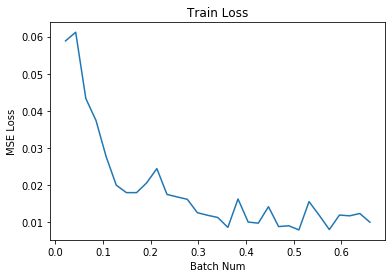

In [24]:
lossSmoothing = 20
lossIndex = [(i * lossSmoothing)/940 for i in range(len(lossList))]
plt.plot(lossIndex, lossList)
plt.xlabel("Batch Num")
plt.ylabel("MSE Loss")
plt.title("Train Loss")

In [25]:
len(trainDataset)

1565

In [26]:
validArr = np.array(validMetrics)
#print(validArr.shape)

validArr.shape

(3, 3, 173)

[[ 1.         -0.02019732]
 [-0.02019732  1.        ]]
[[1.         0.90151085]
 [0.90151085 1.        ]]
[[1.         0.90657316]
 [0.90657316 1.        ]]


Text(0.5, 1.0, 'validation eval')

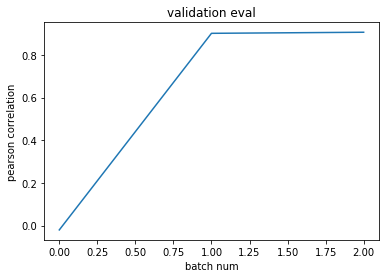

In [27]:
validArr = np.array(validMetrics)
#print(validArr.shape)

test = validArr[1,:,:]
#np.corrcoef(test[1], test[2])

iterList = []
corrList = []
#go through each validation step
for i in range(validArr.shape[0]): 
    subDf = pd.DataFrame(validArr[i].T)
    subDf.columns = ["loss", "pred", "true"]
    corr = np.corrcoef(subDf["pred"], subDf["true"])
    corrList.append(corr[1, 0])
    iterList.append(i)
    print(corr)
    
plt.plot(iterList, corrList)
plt.xlabel("batch num")
plt.ylabel("pearson correlation")
plt.title("validation eval")

Text(0, 0.5, 'prediction')

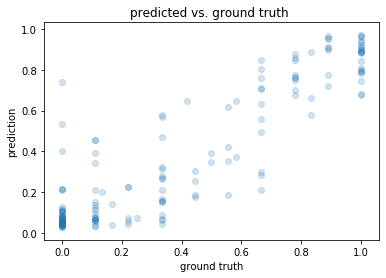

In [28]:
plt.scatter(subDf["true"], subDf["pred"], alpha = .2)
plt.title("predicted vs. ground truth ")
plt.xlabel("ground truth")
plt.ylabel("prediction")

In [29]:
print(x)
print(label)
print()

NameError: name 'x' is not defined

In [ ]:
loss_func(x, label)

In [ ]:
plt.plot(trainDf["testLoss"].dropna())

In [ ]:
valX

In [ ]:
vLabel

In [ ]:
x

In [ ]:
label